# This notebook compares the PSD from celerite to the periodogram and determines the noise level

In [ ]:
import celerite
from celerite.terms import Matern32Term, JitterTerm
from mind_the_gaps.models.celerite.celerite_models import DampedRandomWalk as DRW, Lorentzian as Matern_cel
from mind_the_gaps.models.psd_models import BendingPowerlaw as BPL, SHO, Lorentzian as Lor, Matern32, Jitter
from mind_the_gaps.simulator import *
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from multiprocessing import Pool
from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum
from scipy.stats import ks_1samp, chi2

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def log_probability(params):
    """https://celerite.readthedocs.io/en/stable/tutorials/modeling/"""
    gp.set_parameter_vector(params)

    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return lp + gp.log_likelihood(y)

cores = 12

Lightcurve duration: 1000.02 d
Break timescale: 32.17 d
Model variance: 1.00000
Integrated variance: 0.98049
LC variance: 0.97013


Text(0.5, 0, 'Period (d)')

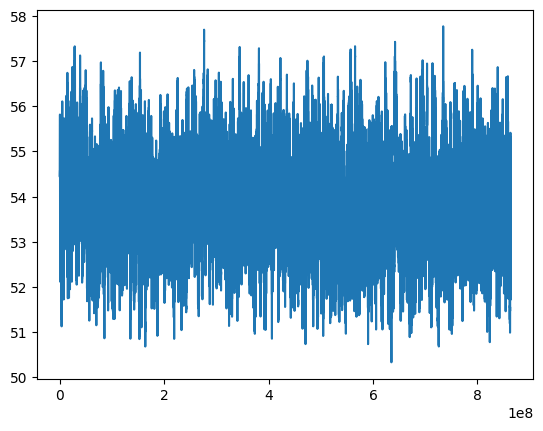

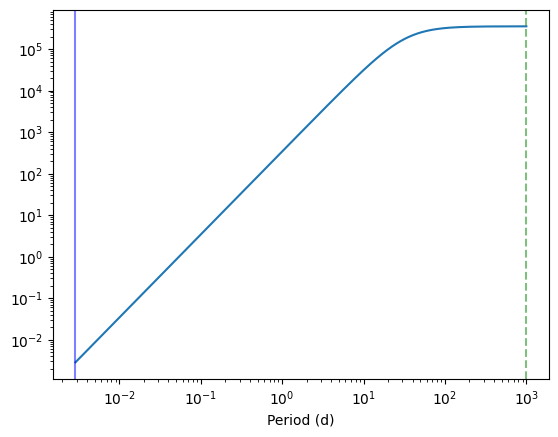

In [11]:
np.random.seed(42)
Npoints = 1000
times = np.linspace(0, 1000, Npoints) * 3600 * 24 # seconds
exposures = 1000 * np.ones(Npoints) # seconds
duration = times[-1] + 1.5 * exposures[-1] - (times[0])
print("Lightcurve duration: %.2f d" % (duration / 3600 /24))
sim_dt = 1 / 4 * np.min(exposures)

logS0 = 0
S0 = np.exp(logS0)
logw0 = -13
w0 = np.exp(logw0)
break_timescale = 1 / (w0 / 2 / np.pi) / 3600 / 24 
print("Break timescale: %.2f d" % break_timescale)
psd_model = BPL(S0=S0, omega0=np.exp(-13))
minimum_frequency = 1 / (duration)
maximum_frequency = 1 / (sim_dt)
fnyq = maximum_frequency

extension_factor = 10
df_int = 1 / (duration * extension_factor)
int_freq = np.arange(minimum_frequency, fnyq, df_int) # frequencies over which to integrate
w_int = int_freq * 2 * np.pi
normalization_factor =  2 / np.sqrt(2 * np.pi) # this factor accounts for the fact that we only integrate positive frequencies and the 1 / sqrt(2pi) from the Fourier transform
var = np.sum(psd_model(w_int)) * df_int * 2 * np.pi * normalization_factor

lc = simulate_lightcurve(times, psd_model,
                        dt=sim_dt, 
                         extension_factor=extension_factor)

plt.plot(lc.time, lc.countrate)
plt.gca().ticklabel_format(useOffset=False)
print("Model variance: %.5f" % S0)
print("Integrated variance: %.5f" % var)
print("LC variance: %.5f" % np.var(lc.countrate))

plt.figure()
plt.plot(1 / int_freq / 3600 / 24, psd_model(w_int))
plt.axvline(1 / minimum_frequency/ 3600 / 24, color="green", alpha=0.5, ls="--")
plt.axvline(1 / maximum_frequency / 3600 / 24, alpha=0.5, color="blue")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Period (d)")

# add gaussian noise

(<mind_the_gaps.models.celerite_models.DampedRandomWalk object at 0x7fd30cfb4c40> + JitterTerm(-0.6931471805599453))


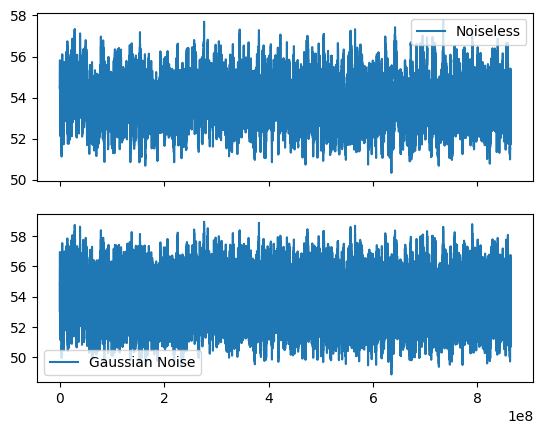

In [12]:
signoise = 0.5
ynoise = lc.countrate + np.random.normal(0, signoise, size=lc.n)
time = lc.time
# create noisy lightcurve
lc_gauss = Lightcurve(time, counts=ynoise, dt=sim_dt, skip_checks=True, input_counts=False)
y = lc_gauss.countrate
Q = 1/ 2
w0 = 2 * np.pi / (30 * u.d).to(u.s).value
S0 = np.var(lc.countrate)
S_0_N_bounds = (-30, 15)
log_omega0_N_bounds = (-25, -1)  # 0 to 200 in period (days)
nwalkers = 12
bounds = dict(log_S0=S_0_N_bounds, log_omega0=log_omega0_N_bounds)
# the second DRW is just to fit the white noise
kernel = DRW(log_S0=np.log(S0), log_omega0=np.log(w0),
                                 bounds=bounds) + JitterTerm(log_sigma=np.log(signoise),
                                 bounds=dict(log_sigma=(-10, 20)))
print(kernel)

fig, axes = plt.subplots(2,1, sharex=True)
axes[0].plot(time, lc.countrate, label="Noiseless")
axes[0].legend()

axes[1].plot(lc_gauss.time, lc_gauss.countrate, label="Gaussian Noise")
axes[1].legend()

In [15]:
gp = celerite.GP(kernel, mean=np.mean(y), fit_mean=False, fit_white_noise=False) 
gp.compute(time, yerr=1e-12)  # important leave it uncertainty free
initial_params = gp.get_parameter_vector()
solution = minimize(neg_log_like, 
                    initial_params, method="L-BFGS-B", bounds=gp.get_parameter_bounds(), 
                    args=(y, gp))

('kernel:terms[0]:log_S0', 'kernel:terms[0]:log_omega0', 'kernel:terms[1]:log_sigma', 'mean:value')
[ -0.03795154 -12.93442081  -0.69349513]
[ -0.03795154 -12.93442081  -0.69349513]
Derived sigma: 0.50 (Input: 0.50)
Ratio ampltiudes
0.9627595969040723
Ratio breaks
1.067777294734881


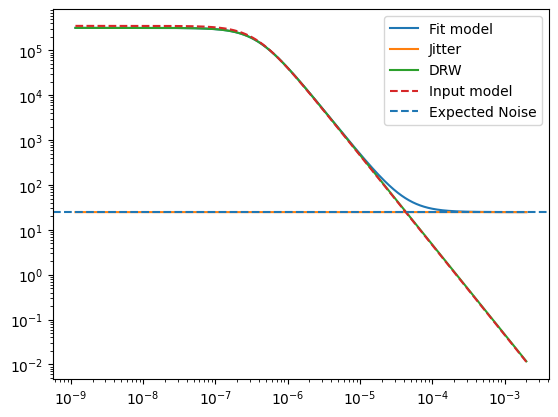

In [14]:
print(gp.parameter_names)
print(solution.x)
df = 1 / (lc.tseg)
fnyq = 1 / (2 * lc.dt)
frequencies = np.arange(df, fnyq, df)
w = frequencies * 2 * np.pi

print(solution.x)
print("Derived sigma: %.2f (Input: %.2f)" % (np.exp(solution.x[-1]), signoise))
gp.set_parameter_vector(solution.x)
# add sigma to PSD
noiselevel = np.ones(len(frequencies)) * 2 * lc.dt * np.exp(solution.x[-1])**2 / (2 * np.pi * normalization_factor)
psd = gp.kernel.get_psd(w)  + noiselevel

plt.figure()
plt.plot(frequencies, psd, label="Fit model")
plt.plot(frequencies, noiselevel , label="Jitter")
plt.plot(frequencies, gp.kernel.get_psd(w), label="DRW")
plt.yscale("log")
plt.xscale("log")

plt.plot(frequencies, psd_model(w), label="Input model", ls="--")

print("Ratio ampltiudes")
print(np.exp(solution.x)[0] / np.exp(logS0))
print("Ratio breaks")
print(np.exp(solution.x)[1] / np.exp(logw0))
plt.axhline(2 * lc.dt * signoise**2 / (2 * np.pi * normalization_factor), ls="--", label="Expected Noise")
plt.legend()

# Compute regular periodograms absolute normalization

In [7]:
ps = Powerspectrum.from_lightcurve(lc, norm="abs")
ps_gauss = Powerspectrum.from_lightcurve(lc_gauss, norm="abs")

noiseless periodograms

KstestResult(statistic=0.0005257083534330464, pvalue=0.7258496129024185, statistic_location=0.16220338696017994, statistic_sign=-1)


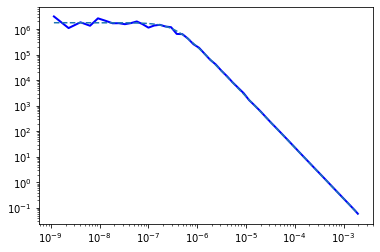

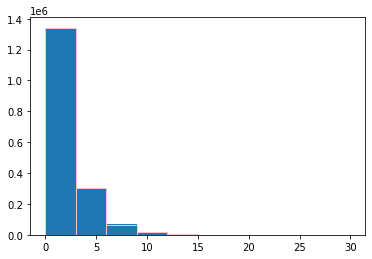

In [8]:
log_rb_ps = ps.rebin_log(f=0.3)
plt.plot(log_rb_ps.freq, log_rb_ps.power, 
         lw=2, color='blue', label="Periodogram")
celerite_renorm  = psd_model(w) * 2 * np.pi * normalization_factor
plt.plot(frequencies, celerite_renorm, 
         label="Celerite (Input Model)", ls="--")

plt.yscale("log")
plt.xscale("log")

# compare results with Chi_2
chi2dist = chi2(2)
plt.figure()
ratio = 2 * ps.power / celerite_renorm
values, bins, _ = plt.hist(ratio, density=False)
plt.hist(chi2dist.rvs(size=len(ps.power)), bins=bins, 
         edgecolor="pink", facecolor="None")
kstest_res = ks_1samp(ratio, chi2dist.cdf)
print(kstest_res)


noisy periodogram

KstestResult(statistic=0.926551322277632, pvalue=0.0, statistic_location=9.496891998019157, statistic_sign=-1)


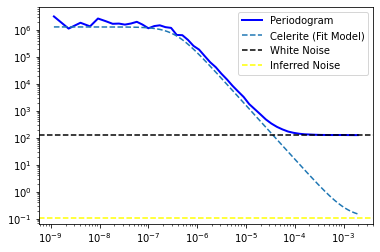

<Figure size 432x288 with 0 Axes>

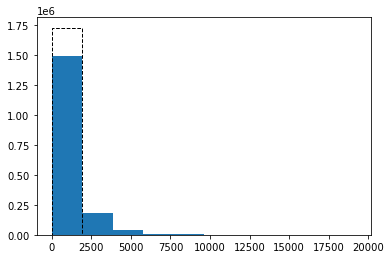

In [9]:
ps_gauss_rebin = ps_gauss.rebin_log(f=0.3)
plt.plot(ps_gauss_rebin.freq, ps_gauss_rebin.power, 
         lw=2, color='blue', label="Periodogram")

 
celerite_renorm  = psd * 2 * np.pi * normalization_factor
plt.plot(frequencies, celerite_renorm, 
         label="Celerite (Fit Model)", ls="--")

plt.yscale("log")
plt.xscale("log")

# noise level
noise = 2 * lc.dt * signoise**2
plt.axhline(noise, ls="--", color="black", label="White Noise")
inferred_noise = 2 * lc.dt * np.exp(solution.x[-1])**2
plt.axhline(inferred_noise, ls="--", color="yellow", label="Inferred Noise")
plt.legend()

# compare results with Chi_2
chi2dist = chi2(2)
plt.figure()
ratio = 2 * ps_gauss.power / celerite_renorm
plt.figure()
values, bins, _ = plt.hist(ratio, density=False)
plt.hist(chi2dist.rvs(size=len(ps_gauss.power)), bins=bins, 
         edgecolor="black", facecolor="None", ls="--")
kstest_res = ks_1samp(ratio, chi2dist.cdf)
print(kstest_res)